# Modeling and Simulation in Python

Chapter 13

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code from previous chapters

`make_system`, `plot_results`, and `calc_total_infected` are unchanged.

In [3]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= np.sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [4]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', label='Susceptible')
    plot(I, '-', label='Infected')
    plot(R, ':', label='Recovered')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [5]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return get_first_value(results.S) - get_last_value(results.S)

Here's an updated version of `run_simulation` that uses `unpack`.

In [6]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for t in linrange(t0, t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

**Exercise:** Write a version of `update_func` that uses `unpack`.

In [7]:
# Original

def update_func(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [8]:
# Solution goes here

Test the updated code with this example.

In [9]:
system = make_system(0.333, 0.25)
results = run_simulation(system, update_func)
results.head()

,S,I,R
0,0.988889,0.011111,0.000000
1,0.985230,0.011992,0.002778
2,0.981296,0.012929,0.005776
3,0.977071,0.013921,0.009008
4,0.972541,0.014970,0.012488


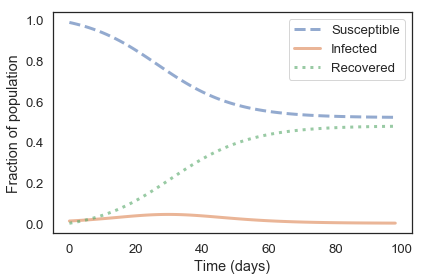

In [10]:
plot_results(results.S, results.I, results.R)

### Sweeping beta

Make a range of values for `beta`, with constant `gamma`.

In [14]:
beta_array = linspace(.01, 1, 100)
#gamma = 0.25

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

Run the simulation once for each value of `beta` and print total infections.

In [12]:
for beta in beta_array:
    system = make_system(beta, gamma)
    results = run_simulation(system, update_func)
    print(system.beta, calc_total_infected(results))

0.1 0.0072309016649785285
0.2 0.038410532615067994
0.30000000000000004 0.33703425948982
0.4 0.6502429153895082
0.5 0.8045061124629623
0.6 0.8862866308018508
0.7000000000000001 0.9316695082755875
0.8 0.9574278300784942
0.9 0.9720993156325133
1.0 0.9803437149675784
1.1 0.9848347293510136


Wrap that loop in a function and return a `SweepSeries` object.

In [12]:
def sweep_beta(beta_array, gamma):
    """Sweep a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, update_func)
        sweep[system.beta] = calc_total_infected(results)
    return sweep

Sweep `beta` and plot the results.

In [13]:
infected_sweep = sweep_beta(beta_array, gamma)

In [14]:
label = 'gamma = ' + str(gamma)
plot(infected_sweep, label=label)

decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected')

savefig('figs/chap06-fig01.pdf')

### Sweeping gamma

Using the same array of values for `beta`

In [15]:
beta_array

And now an array of values for `gamma`

In [16]:
gamma_array = [0.2, 0.4, 0.6, 0.8]

For each value of `gamma`, sweep `beta` and plot the results.

In [17]:
for gamma in gamma_array:
    infected_sweep = sweep_beta(beta_array, gamma)
    label = 'γ = ' + str(gamma)
    plot(infected_sweep, label=label)
    
decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected',
         loc='upper left')

savefig('figs/chap06-fig02.pdf')

** Exercise:**  Suppose the infectious period for the Freshman Plague is known to be 2 days on average, and suppose during one particularly bad year, 40% of the class is infected at some point.  Estimate the time between contacts.

In [18]:
# Solution goes here

In [19]:
# Solution goes here

In [20]:
# Solution goes here